In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from torchvision.datasets import CIFAR10
import torch


def plot_client_data(settings_files):
    train_data = CIFAR10(root='../data', train=True)
    train_data.targets = torch.tensor(train_data.targets)

    fig, ax = plt.subplots(len(settings_files), 1, figsize=(16, 10))

    for j, set in enumerate(settings_files):

        settings_path = f"../settings/{set}"
        local_indices = []
        with open(f"{settings_path}/data_splits.npy", "rb") as f:
            public_indices = np.load(f)
            try:
                while True:
                    local_indices.append(np.load(f))
            except:
                pass
        
        client_targets = [train_data.targets[indices].tolist() for indices in local_indices]
        n_clients = len(client_targets)
        n_classes = 10

        label_count_matrix = np.array([[np.sum(np.array(client_targets[i]) == c) for c in range(10)] for i in range(n_clients)])
        data_dict = {}
        for i in range(n_classes):
            data_dict[f"label_count{i}"] = label_count_matrix[:, i]

        df = pd.DataFrame(data_dict)

        df.plot(ax=ax[j], kind='bar', stacked=True, rot=0)
        ax[j].get_legend().remove()
    ax[0].legend(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], mode="expand", ncol=10, bbox_to_anchor=(0,1.02,1,0.15), loc="upper left")
    plt.show()

def plot_test_public_data(settings_files):

    settings_path = f"../settings/{settings_files[0]}"
    with open(f"{settings_path}/data_splits.npy", "rb") as f:
        public_indices = np.load(f)

    test_data = CIFAR10(root='../data', train=False)
    train_data = CIFAR10(root='../data', train=True)
    train_data.targets = torch.tensor(train_data.targets)
    test_data.targets = torch.tensor(test_data.targets)
    test_public_targets = [test_data.targets.tolist()]
    test_public_targets.append(train_data.targets[public_indices].tolist())

    label_count_matrix = np.array([[np.sum(np.array(targets) == c) for c in range(10)] for targets in test_public_targets])

    n_classes = 10
    data_dict = {}
    for i in range(n_classes):
        data_dict[f"label_count{i}"] = label_count_matrix[:, i]

    fig, ax = plt.subplots(figsize=(12, 8))
    df = pd.DataFrame(data_dict, index=["Test data", "Public data"])
    df.plot(ax=ax, kind='bar', stacked=True, rot=0)
    ax.legend(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], mode="expand", ncol=10, bbox_to_anchor=(0,1.01,1,0.1), loc="upper left")
    ax.tick_params(axis='both', which='major', labelsize=18)
    plt.show()    

def plot_client_training(settings_files, alg, weight_scheme, student_model=None, loss=None):    
    student_model = student_model + "_" if student_model is not None else ""
    loss = loss + "_" if loss is not None else ""

    dataset = settings_files[0].split('_')[0]
    
    fig, ax = plt.subplots(2, len(seeds), figsize=(15,6))
    for i, set in enumerate(settings_files):
        results_path = f"../results/{dataset}/{alg}/{set}_{student_model}{loss}w{weight_scheme}"
        client_accs = []
        with open(f"{results_path}/client_accuracy.npy", "rb") as f:
            try:
                while True:
                    client_accs.extend([np.load(f)])
            except:
                pass

        client_losses = []
        with open(f"{results_path}/client_loss.npy", "rb") as f:
            try:
                while True:
                    client_losses.extend([np.load(f)])
            except:
                pass

        for accs in client_accs:
            ax[0][i].plot(accs)

        for losses in client_losses:
            ax[1][i].plot(losses)
    plt.show()  

def plot_student_results(settings_files, n_pub, model, loss, weight_scheme):
    fig, ax = plt.subplots(len(settings_files), len(n_pub), figsize=(15,15))
    test_acc_lists = [[] for _ in range(len(n_pub))]
    ensemble_test_acc = [[] for _ in range(len(settings_files))]
    dataset = settings_files[0].split('_')[0]

    for i, set in enumerate(settings_files):
        results_path = f"../results/{dataset}/feded/{set}_{model}_{loss}_w{weight_scheme}"
        for j, n in enumerate(n_pub):
            with open(f"{results_path}/student_train_results{n}.npy", "rb") as f:
                train_accs = np.load(f)
                train_losses = np.load(f)
                val_accs = np.load(f)
                val_losses = np.load(f)

            with open(f"{results_path}/student_test_results_{n}.npy", "rb") as f:
                test_results = np.load(f)

            ax[i][j].plot(train_accs)
            ax[i][j].plot(val_accs)
            ax[i][j].set_ylim([10,100])
            test_acc_lists[j].append(test_results[0])
            
        with open(f"{results_path}/ensemble_test_acc.npy", "rb") as f:
                ensemble_test_acc[i] = np.load(f)[0]
        
    plt.show()
    print("Test accuracy \n\n")
    print("{:<15} {:<10} {:<10} {:<10} {:<10} {:<10} | {:<10}".format('Run\Public size', n_pub[0], n_pub[1], n_pub[2], n_pub[3], n_pub[4], 'Ensemble'))
    for run in range(len(settings_files)):
        print("{:<15} {:<10} {:<10} {:<10} {:<10} {:<10} | {:<10} ".format(run, 
                                                  test_acc_lists[0][run],
                                                  test_acc_lists[1][run],
                                                  test_acc_lists[2][run],
                                                  test_acc_lists[3][run],
                                                               test_acc_lists[4][run],
                                                    ensemble_test_acc[run]))
    print("")
    print("{:<15} {:<10.2f} {:<10.2f} {:<10.2f} {:<10.2f} {:<10.2f} {:<10.2f}".format('Mean',
                                                     np.mean(test_acc_lists[0]),
                                                     np.mean(test_acc_lists[1]),
                                                     np.mean(test_acc_lists[2]),
                                                     np.mean(test_acc_lists[3]),
                                                                np.mean(test_acc_lists[4]),
                                                                np.mean(ensemble_test_acc)))
    print("{:<15} {:<10.2f} {:<10.2f} {:<10.2f} {:<10.2f} {:<10.2f} {:<10.2f}".format('Std',
                                                    np.std(test_acc_lists[0]),
                                                    np.std(test_acc_lists[1]),
                                                    np.std(test_acc_lists[2]),
                                                    np.std(test_acc_lists[3]),
                                                            np.std(test_acc_lists[4]),
                                                            np.std(ensemble_test_acc)))

def print_test_results(settings_files, alg):    
    #fig, ax = plt.subplots(1, 2, figsize=(15,6))
    dataset = settings_files[0].split('_')[0]
    test_acc_list = []
    for i, set in enumerate(settings_files):
        results_path = f"../results/{dataset}/{alg}/{set}_w0"

        with open(f"{results_path}/fedavg_test_results.npy", "rb") as f:
            test_accs = np.load(f)
            test_losses = np.load(f)

        #ax[0].plot(test_accs)
        #ax[1].plot(test_losses)
        test_acc_list.append(test_accs[-1])
    # ax[0].set_ylabel("Accuracy")
    # ax[0].set_xlabel("Communication round")
    # ax[1].set_ylabel("Loss")
    # ax[1].set_xlabel("Communication round")
    #plt.show()
    print("{:<8} {:<10}".format('Run', 'Test accuracy'))
    for run in range(len(settings_files)):
        print("{:<8} {:<10}".format(run, test_acc_list[run]))
    print("")
    print("{:<8} {:<10.2f}".format('Mean', np.mean(test_acc_list)))
    print("{:<8} {:<10.2f}".format('Std', np.std(test_acc_list)))
                                                

In [41]:
distribution = "niid0.1"
seeds = [0,2,3,4,5]
n_clients = 10
model = "cifar10_resnet18"
settings_files = [f"{model}_c{n_clients}_{distribution}_s{i}" for i in seeds]

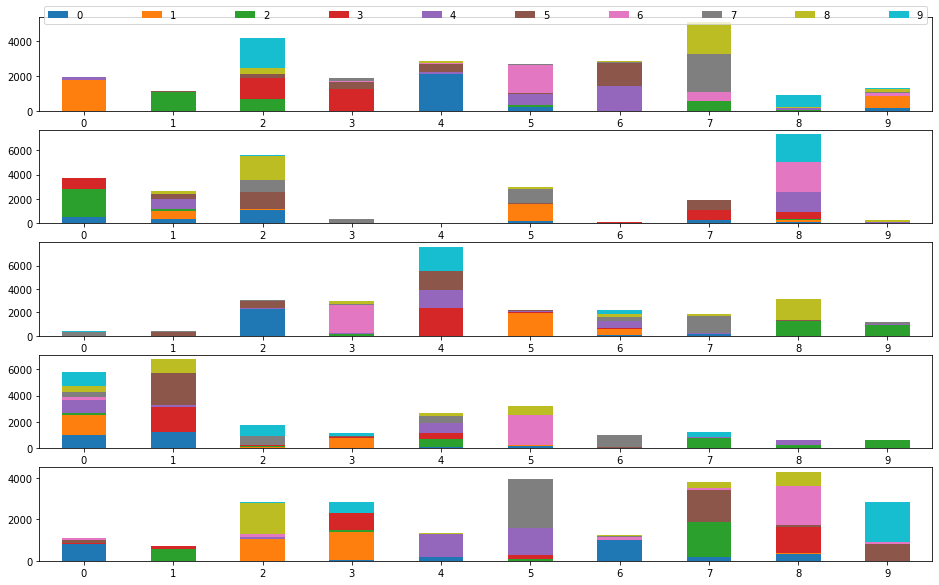

In [42]:
plot_client_data(settings_files)

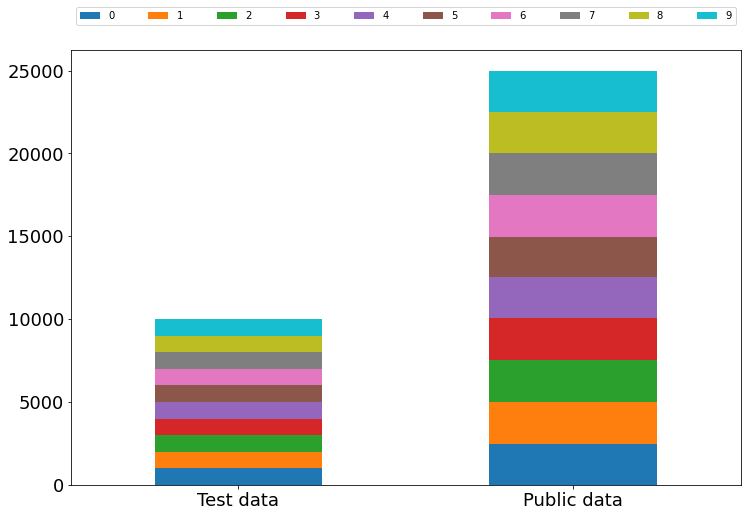

In [10]:
plot_test_public_data(settings_files)

# FedAVG
```
class Cifar10_Resnet(nn.Module):
    def __init__(self):
        super(Cifar10_Resnet, self).__init__()
        base = resnet18(pretrained=False)
        self.base = nn.Sequential(*list(base.children())[:-1])
        in_features = base.fc.in_features
        self.drop = nn.Dropout()
        self.final = nn.Linear(in_features, 10)
    
    def forward(self,x):
        x = self.base(x)
        x = self.drop(x.view(-1,self.final.in_features))
        return self.final(x)
```
Centralized model ~ 56 % accuracy

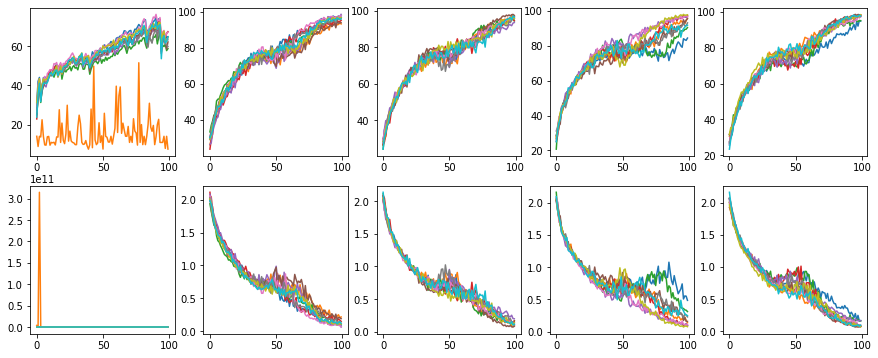

In [31]:
plot_client_training(settings_files, "fedavg", 0)

In [32]:
print_test_results(settings_files, "fedavg")

Run      Test accuracy
0        34.88     
1        51.16     
2        50.98     
3        51.18     
4        50.77     

Mean     47.79     
Std      6.46      


In [23]:
print_test_results(settings_files, "fedprox")

Run      Test accuracy
0        39.59     
1        43.17     
2        35.92     
3        41.34     
4        35.89     

Mean     39.18     
Std      2.91      


# FedED
```
class Mnist_Cnn2(nn.Module):
    def __init__(self):
        super(Mnist_Cnn2, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 5, 1, 2)
        self.conv2 = nn.Conv2d(16, 32, 5, 1, 2)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.pool1 = nn.MaxPool2d(2)
        self.pool2 = nn.MaxPool2d(2)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
        
loss = nn.MSELoss()
```

$$
  \mathbf{\hat{z}} = \sum_{k\in\mathcal{K}_t} \omega_k \mathbf{z}^k, \quad \omega^k = \frac{N^k}{\sum_{k\in\mathcal{K}_t} N^k}
$$

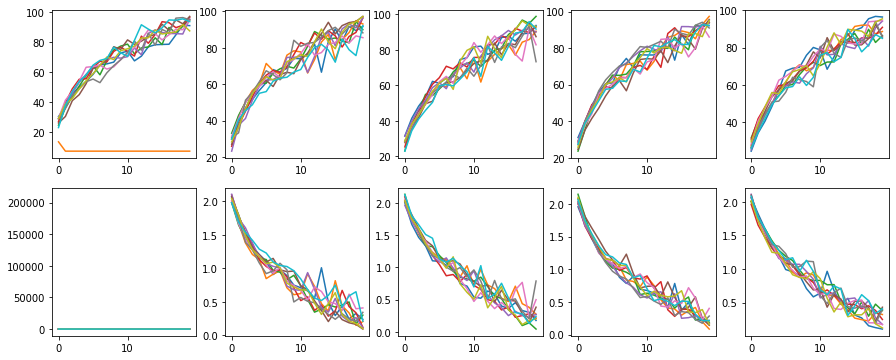

In [14]:
plot_client_training(settings_files, "feded", 0, "resnet18", "mse")

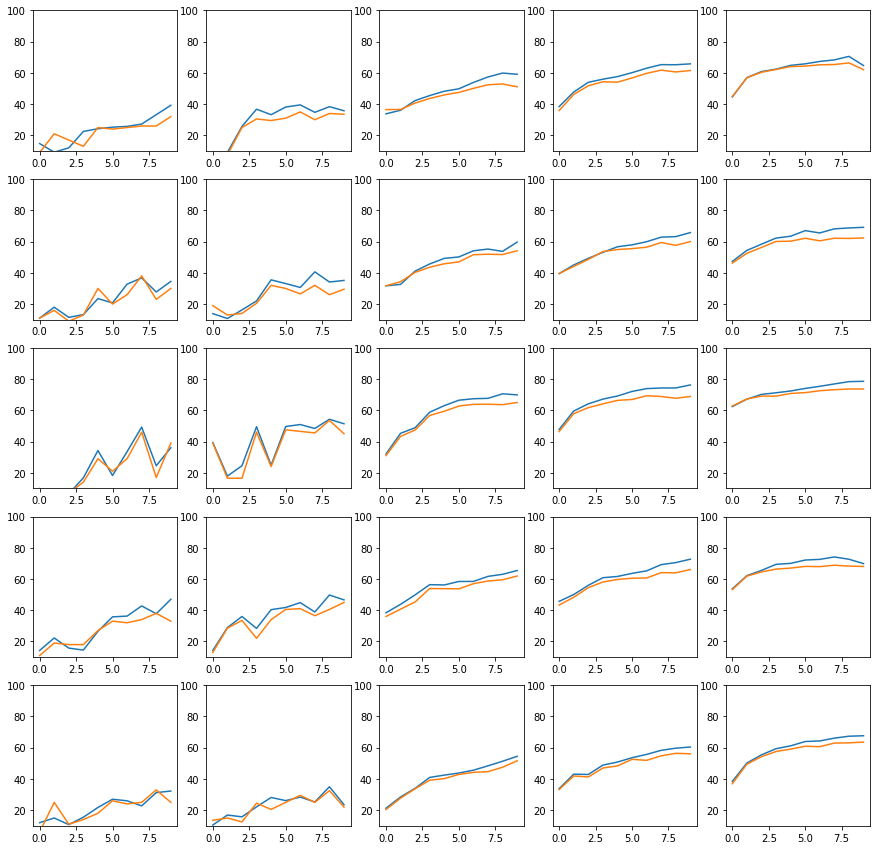

Test accuracy 


Run\Public size 500        1000       5000       10000      25000      | Ensemble  
0               20.59      19.47      33.05      37.55      36.78      | 41.27      
1               16.68      18.25      31.69      35.14      38.35      | 39.8       
2               15.15      19.35      27.7       29.76      31.66      | 32.38      
3               18.47      22.15      30.02      34.74      36.39      | 39.66      
4               19.74      17.33      31.79      36.31      39.8       | 39.07      

Mean            18.13      19.31      30.85      34.70      36.60      38.44     
Std             1.99       1.62       1.85       2.66       2.75       3.11      


In [26]:
plot_student_results(settings_files, [500, 1000, 5000, 10000, 25000], "resnet18", "mse", 0)

# FedED weight scheme 1

$$
  \mathbf{\hat{z}}_c = \sum_{k\in\mathcal{K}_t} \omega^c_k \mathbf{z}^k_c, \quad \omega^k_c = \frac{N_c^k}{\sum_{k\in\mathcal{K}_t} N_c^k}
$$

In [36]:
#plot_client_training("mnist", "feded", 1, "cnn2")

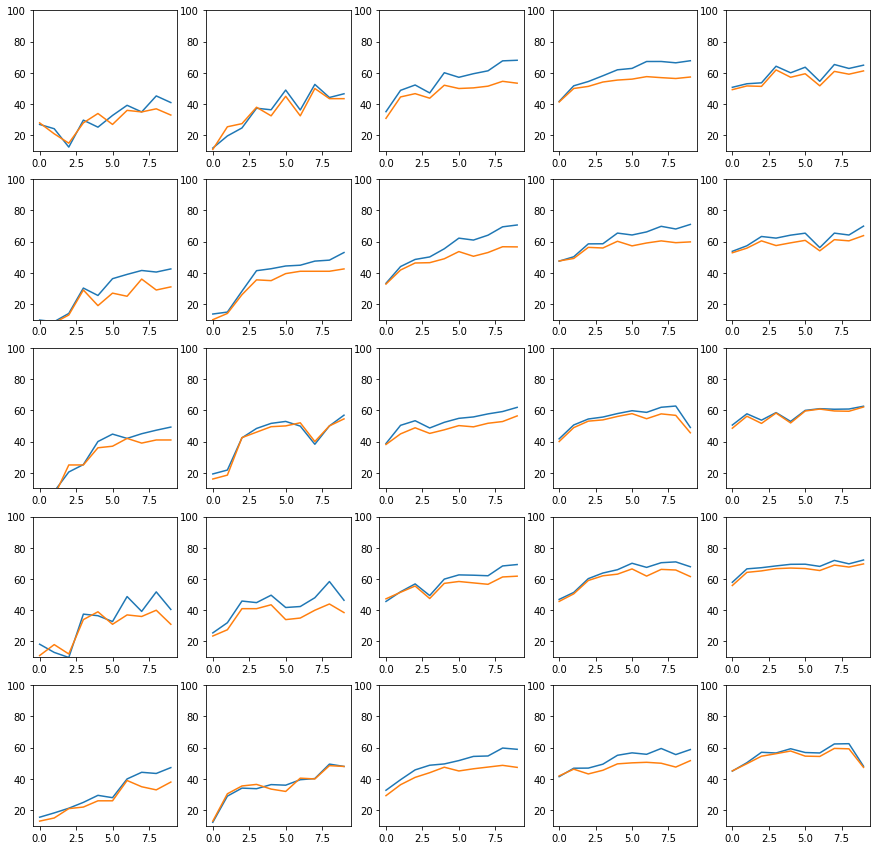

Test accuracy 


Run\Public size 500        1000       5000       10000      25000      | Ensemble  
0               24.06      28.0       39.69      41.15      39.33      | 40.85      
1               19.49      25.5       36.32      39.83      40.73      | 43.13      
2               24.04      25.93      33.64      25.5       34.22      | 38.34      
3               13.74      15.81      25.94      29.23      34.18      | 37.33      
4               23.0       26.88      33.19      34.06      34.47      | 39.53      

Mean            20.87      24.42      33.76      33.95      36.59      39.84     
Std             3.94       4.39       4.54       6.00       2.85       2.02      


In [27]:
plot_student_results(settings_files, [500, 1000, 5000, 10000, 25000], "resnet18", "mse", 1)

# FedED weight scheme 2

1. Träna autoencoder $H_k$ på privat data $\mathcal{D}_k$.
2. För varje publikt dataexempel $x_j$, notera loss
$$ l_k(x_j) = MSE(H_k(x_j), x_j). $$
3. Ange vikt 
$$\omega^j_k = \frac{1}{l_k(x_j)^6}.$$
3. Bilda viktat medelvärde för logits med aktiva klienter $\mathcal{K}_t$
$$
  \mathbf{\hat{z}}_j = \sum_{k\in\mathcal{K}_t} \omega^j_k \mathbf{z}^j_k. %\quad \omega^k_c = \frac{N_c^k}{\sum_{k\in\mathcal{K}_t} N_c^k}
$$
4. Normalisera.

Student loss: 
$$\mathbf{z}_j = F_S(x_j) \qquad MSE(\mathbf{z}_j, \mathbf{\hat{z}}_j)$$
<!-- $$
  \mathbf{\bar{z}}_c = \sum_{k\in\mathcal{K}_t} N_c^k \mathbf{z}^k_c \\
  \mathbf{\hat{z}}_c = \frac{\mathbf{\bar{z}}_c}{\sum_c \mathbf{\bar{z}}_c}
$$ -->

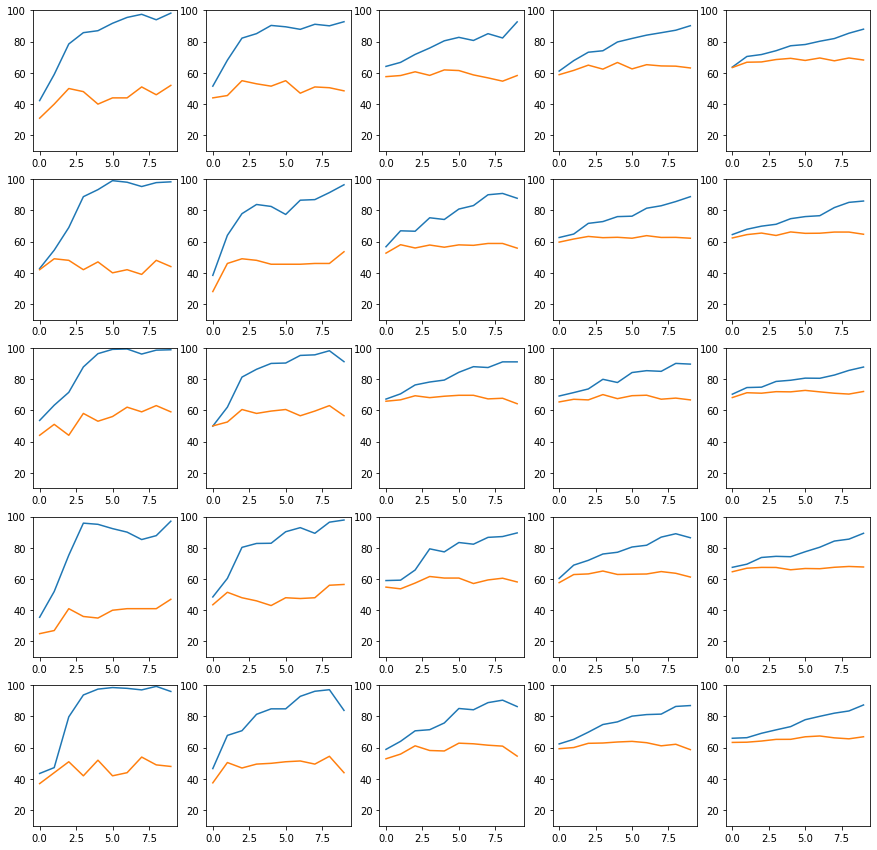

Test accuracy 


Run\Public size 500        1000       5000       10000      25000      | Ensemble  
0               27.65      29.38      35.25      36.04      36.98      | 37.15      
1               27.65      28.32      32.99      35.79      38.3       | 38.3       
2               25.95      25.43      28.37      28.63      30.45      | 32.27      
3               26.93      31.83      36.41      36.07      38.91      | 40.21      
4               24.85      25.62      34.37      37.57      36.17      | 36.93      

Mean            26.61      28.12      33.48      34.82      36.16      36.97     
Std             1.08       2.40       2.79       3.16       3.01       2.62      


In [28]:
plot_student_results(settings_files, [500, 1000, 5000, 10000, 25000], "resnet18", "ce", 2)


Student loss: 
$$CE(\mathbf{t}_j, \mathbf{\hat{t}}_j)$$

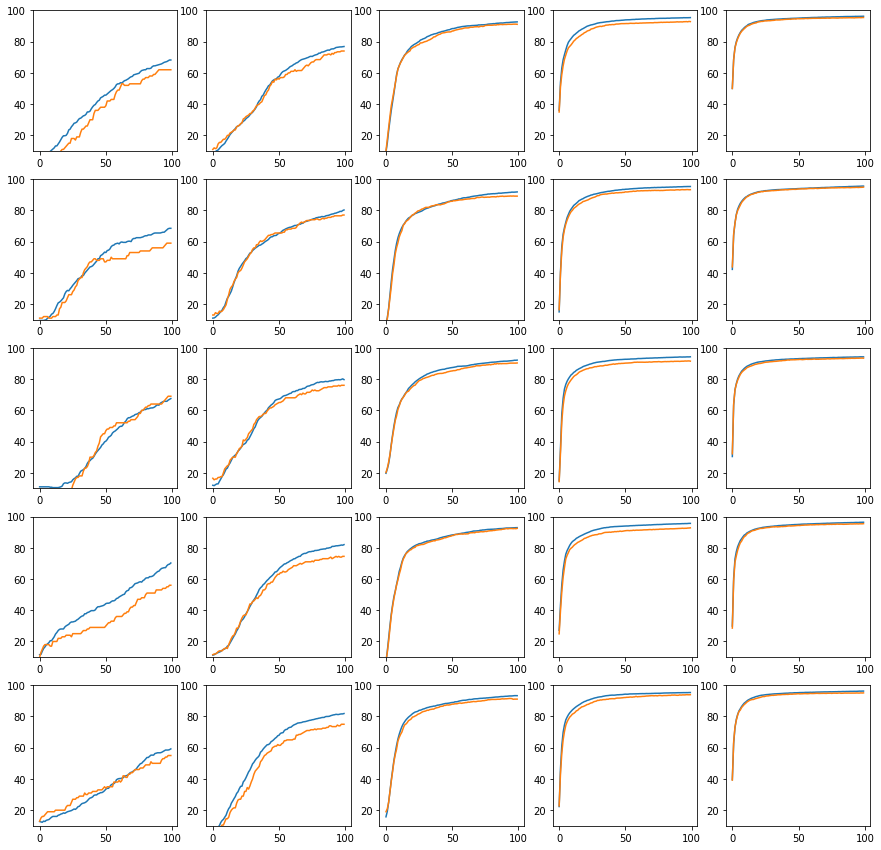

Test accuracy 


Run\Public size 500        1000       5000       15000      30000      | Ensemble  
0               55.86      68.89      89.26      92.98      94.11      | 92.9       
1               58.24      71.19      87.06      90.16      90.63      | 88.87      
2               59.36      73.91      88.34      91.54      91.75      | 89.83      
3               55.51      74.52      88.69      91.43      90.96      | 89.45      
4               49.63      72.81      89.02      92.51      92.08      | 90.71      

Mean            55.72      72.26      88.47      91.72      91.91      90.35     
Std             3.37       2.03       0.77       0.98       1.22       1.41      


In [11]:
plot_student_results(settings_files, [500, 1000, 5000, 15000, 30000], "cnn2", "ce", 2)